In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report
from xgboost import XGBClassifier
import joblib

In [2]:
# Cambia esta ruta por la ruta local de tu archivo
file_path = "Data/url_phishing_data.csv"
df = pd.read_csv(file_path)
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.progarchives.com/album.asp?id=61737,46,20,zero,3,zero,0,1,0,0,...,1,one,0,627,6678,78526,0,0,5,phishing
1,http://signin.eday.co.uk.ws.edayisapi.dllsign....,128,120,0,10,0,0,0,0,0,...,1,zero,0,300,65,0,0,1,0,phishing
2,http://www.avevaconstruction.com/blesstool/ima...,52,25,0,3,0,0,0,0,0,...,1,zero,0,119,1707,0,0,1,0,phishing
3,http://www.jp519.com/,21,13,0,2,0,0,0,0,0,...,1,one,0,130,1331,0,0,0,0,legitimate
4,https://www.velocidrone.com/,28,19,0,2,0,0,0,0,0,...,0,zero,0,164,1662,312044,0,0,4,legitimate


In [3]:
df.describe()

,length_url,length_hostname,nb_dots,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,...,right_clic,empty_title,domain_in_title,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
count,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.0,11481.000000,11481.000000,11481.000000,...,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,1.148100e+04,11481.000000,11481.000000,11481.000000
mean,61.203902,21.129344,2.496298,0.022124,0.140928,0.168975,0.0,0.299364,0.334117,0.006707,...,0.001394,0.125425,0.773713,0.074122,492.388468,4059.613884,8.630862e+05,0.019598,0.535493,3.190837
std,56.795786,10.633279,1.421589,0.155721,0.365781,0.871249,0.0,1.040306,1.165724,0.081623,...,0.037307,0.331214,0.418445,0.261981,811.349827,3110.854830,2.000251e+06,0.138619,0.498760,2.531696
min,13.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,33.000000,15.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,85.000000,966.000000,0.000000e+00,0.000000,0.000000,1.000000
50%,47.000000,19.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,246.000000,4003.000000,2.187000e+03,0.000000,1.000000,3.000000
75%,71.000000,24.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,452.000000,7006.000000,3.733190e+05,0.000000,1.000000,5.000000
max,1641.000000,214.000000,24.000000,4.000000,3.000000,19.000000,0.0,19.000000,18.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,29829.000000,12873.000000,1.076799e+07,1.000000,1.000000,10.000000


In [4]:
# Revisar columnas con valores tipo texto (como "zero", "one") y convertir a número
# Primero vemos cuáles no son numéricas
non_numeric = df.select_dtypes(include='object').columns
print("Columnas no numéricas:", non_numeric)

Columnas no numéricas: Index(['url', 'ip', 'nb_hyphens', 'domain_with_copyright', 'status'], dtype='object')


In [5]:
for col in non_numeric:
  print(df[col].unique())

['http://www.progarchives.com/album.asp?id=61737'
 'http://signin.eday.co.uk.ws.edayisapi.dllsign.inusingsslpuseridcopartnerid2siteid.zdfxx949xyss1pnbh0soabfdzgdh2kppnu.reippl.com/'
 'http://www.avevaconstruction.com/blesstool/image.htm' ...
 'https://sites.google.com/site/ilyasdxih'
 'http://iceage.wikia.com/wiki/Ice_Age:_Collision_Course'
 'http://www.mousebreaker.com/games/clicker']
['zero' '0' '1' 'one']
['zero' '0' '1' '2' '5' '7' '4' '3' 'one' '8' '9' '6' '17' '11' '14' '24'
 '10' '13' '15' '19' '18' '16' '20' '26' '12' '32' '23']
['one' 'zero' 'One' 'Zero']
['phishing' 'legitimate']


In [6]:
# Convertir 'status' de texto a binario: 'legitimate' → 0, 'phishing' → 1
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})

# Convertir texto 'zero', 'one' por valores numéricos
df.replace({'zero': 0, 'one': 1, 'Zero': 0, 'One': 1}, inplace=True)

C:\Users\Daniel R\AppData\Local\Temp\ipykernel_22232\3272999765.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'zero': 0, 'one': 1, 'Zero': 0, 'One': 1}, inplace=True)


In [7]:
cols_to_change = ['ip', 'nb_hyphens', 'domain_with_copyright']
for col in cols_to_change:
    df[col] = df[col].astype(str).astype(int)

In [8]:
df = df.drop_duplicates()
df = df.drop(columns=['url'])  # La columna 'url' no se usa

In [9]:
# Correlación entre todas las columnas y la variable objetivo (status)
correlation_matrix = df.corr()

# Ver las columnas más correlacionadas con 'status'
cor_target = correlation_matrix['status'].sort_values(ascending=False)
print("Correlación con 'status':")
print(cor_target)

Correlación con 'status':
status                  1.000000
google_index            0.729988
ratio_digits_url        0.356867
phish_hints             0.339979
domain_in_title         0.334847
                          ...   
ratio_nullHyperlinks         NaN
ratio_intRedirection         NaN
ratio_intErrors              NaN
submit_email                 NaN
sfh                          NaN
Name: status, Length: 88, dtype: float64


In [10]:
cor_target = df.corr()['status']
no_corr_columns = cor_target[cor_target.isna()].index.tolist()
df = df.drop(columns=no_corr_columns)

In [11]:
# Ver las columnas más correlacionadas con 'status'
print("Correlación con 'status':")
print(cor_target)

Correlación con 'status':
length_url         0.238638
length_hostname    0.244108
ip                 0.319934
nb_dots            0.202934
nb_hyphens        -0.106822
                     ...   
web_traffic        0.060735
dns_record         0.125779
google_index       0.729988
page_rank         -0.507796
status             1.000000
Name: status, Length: 88, dtype: float64


In [32]:
# Asegúrate de que 'status' sea tipo entero
df['status'] = df['status'].astype(int)

# Calcular correlación con 'status' de todas las columnas numéricas
cor_target = df.corr(numeric_only=True)['status'].drop('status').sort_values(ascending=False)

# Mostrar tabla de correlación
print("Correlación con 'status':")
print(cor_target)


Correlación con 'status':
google_index             0.726897
ratio_digits_url         0.356114
phish_hints              0.337933
domain_in_title          0.333799
ip                       0.319618
nb_qm                    0.290114
length_hostname          0.244081
nb_slash                 0.239897
length_url               0.233651
shortest_word_host       0.228314
ratio_digits_host        0.226708
nb_eq                    0.219922
longest_word_path        0.217559
tld_in_subdomain         0.206643
longest_words_raw        0.204055
nb_dots                  0.202374
prefix_suffix            0.201947
empty_title              0.201915
avg_word_host            0.200006
avg_word_path            0.198088
abnormal_subdomain       0.121925
suspecious_tld           0.117335
ratio_extHyperlinks      0.080214
web_traffic              0.060981
char_repeat              0.008605
right_clic              -0.003330
login_form              -0.019979
onmouseover             -0.021152
iframe                

In [13]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# 1. Separar variables y objetivo
X = df.drop(columns=['status'])
y = df['status']

# 2. Calcular correlación de Pearson
correlation = df.corr()['status'].drop('status')

# 3. Calcular Mutual Information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# 4. Establecer umbral para considerar una feature útil
umbral_pearson = 0.2
umbral_mi = 0.2

# 5. Clasificación de variables
pearson_utiles = correlation[abs(correlation) >= umbral_pearson].index.tolist()
mi_utiles = mi_series[mi_series >= umbral_mi].index.tolist()

# 6. Cruces de listas
ambos_utiles = list(set(pearson_utiles) & set(mi_utiles))
solo_pearson = list(set(pearson_utiles) - set(mi_utiles))
solo_mi = list(set(mi_utiles) - set(pearson_utiles))

# 7. Agrupar todas las útiles (sin filtrar nada por ahora)
columnas_utiles = ambos_utiles + solo_pearson + solo_mi

# 8. Features útiles derivadas del contenido HTML (MI > 0.07)
features_html_utiles = [
    'web_traffic',
    'ratio_extHyperlinks',
    'safe_anchor',
    'links_in_tags',
    'ratio_extRedirection',
    'ratio_extErrors',
    'avg_word_path',
    'avg_word_host',
    'char_repeat',
    'external_favicon',
    'submit_email',
    'sfh',
    'popup_window_size',
    'right_clic',
    'onmouseover',
    # 'shortening_service',
    'nb_extCSS',
    'suspecious_tld',
    'abnormal_subdomain',
    'domain_with_copyright',
    'domain_in_brand',
    'brand_in_subdomain,'
    'nb_semicolumn',
    'whois_registered_domain'
    'brand_in_path'
]

# 9. Features semánticas con sentido contextual (aunque MI = 0)
features_html_semanticas = [
    'iframe',
    'login_form'
]

# 10. Unir todo, pero verificar que las columnas existan en el dataset
features_html_totales = [col for col in (features_html_utiles + features_html_semanticas) if col in df.columns]

# 11. Unir todas las columnas útiles con las HTML
columnas_finales = list(set(columnas_utiles + features_html_totales))

# 12. Crear nuevo DataFrame
df_filtrado = df[columnas_finales + ['status']]

# 13. Confirmación
print(f"Nuevo dataset tiene {df_filtrado.shape[1]} columnas (incluyendo 'status')")
print("Columnas actuales:", sorted(df_filtrado.columns.tolist()))

Nuevo dataset tiene 43 columnas (incluyendo 'status')
Columnas actuales: ['abnormal_subdomain', 'avg_word_host', 'avg_word_path', 'char_repeat', 'domain_age', 'domain_in_brand', 'domain_in_title', 'domain_with_copyright', 'empty_title', 'external_favicon', 'google_index', 'iframe', 'ip', 'length_hostname', 'length_url', 'links_in_tags', 'login_form', 'longest_word_path', 'longest_words_raw', 'nb_dots', 'nb_eq', 'nb_extCSS', 'nb_hyperlinks', 'nb_qm', 'nb_slash', 'nb_www', 'onmouseover', 'page_rank', 'phish_hints', 'prefix_suffix', 'ratio_digits_host', 'ratio_digits_url', 'ratio_extErrors', 'ratio_extHyperlinks', 'ratio_extRedirection', 'ratio_intHyperlinks', 'right_clic', 'safe_anchor', 'shortest_word_host', 'status', 'suspecious_tld', 'tld_in_subdomain', 'web_traffic']


In [14]:
# df.to_csv('Data/URL_Train.csv', index=False)

Correlación con 'status':
google_index             0.728374
ratio_digits_url         0.356175
phish_hints              0.338650
domain_in_title          0.336184
ip                       0.320164
nb_qm                    0.290498
length_hostname          0.243680
nb_slash                 0.238949
length_url               0.235257
shortest_word_host       0.229062
nb_eq                    0.228207
ratio_digits_host        0.226580
longest_word_path        0.217391
tld_in_subdomain         0.206958
longest_words_raw        0.204020
prefix_suffix            0.201283
empty_title              0.200738
nb_dots                  0.200729
avg_word_host            0.199985
avg_word_path            0.197961
abnormal_subdomain       0.120065
suspecious_tld           0.117509
ratio_extHyperlinks      0.081250
web_traffic              0.061131
char_repeat              0.008641
right_clic              -0.003330
iframe                  -0.016815
login_form              -0.019485
onmouseover           

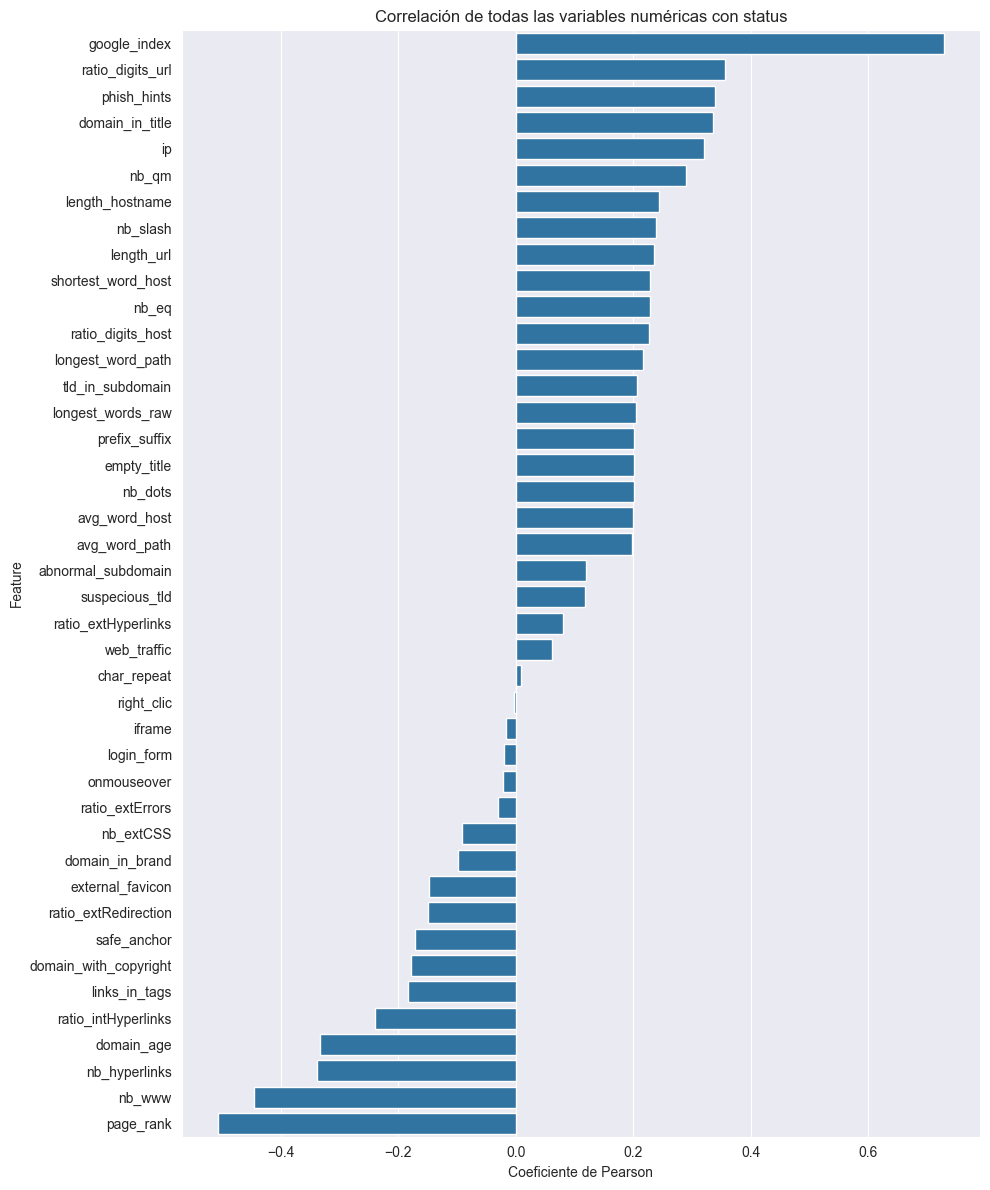

In [69]:
# Asegúrate de que 'status' sea tipo entero
df_filtrado['status'] = df_filtrado['status'].astype(int)

# Calcular correlación con 'status' de todas las columnas numéricas
cor_target = df.corr(numeric_only=True)['status'].drop('status').sort_values(ascending=False)

# Mostrar tabla de correlación
print("Correlación con 'status':")
print(cor_target)

# Visualización
plt.figure(figsize=(10, 12))
sns.barplot(x=cor_target.values, y=cor_target.index)
plt.title('Correlación de todas las variables numéricas con status')
plt.xlabel('Coeficiente de Pearson')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [16]:
df_filtrado.to_csv('Data/URL_Train.csv', index=False)

In [17]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8001 entries, 0 to 8000
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   abnormal_subdomain     8001 non-null   int64  
 1   longest_word_path      8001 non-null   int64  
 2   domain_in_title        8001 non-null   int64  
 3   web_traffic            8001 non-null   int64  
 4   google_index           8001 non-null   int64  
 5   char_repeat            8001 non-null   int64  
 6   length_url             8001 non-null   int64  
 7   domain_age             8001 non-null   int64  
 8   nb_www                 8001 non-null   int64  
 9   ratio_intHyperlinks    8001 non-null   float64
 10  nb_extCSS              8001 non-null   int64  
 11  nb_eq                  8001 non-null   int64  
 12  longest_words_raw      8001 non-null   int64  
 13  domain_in_brand        8001 non-null   int64  
 14  tld_in_subdomain       8001 non-null   int64  
 15  length_ho

# Entrenamiento

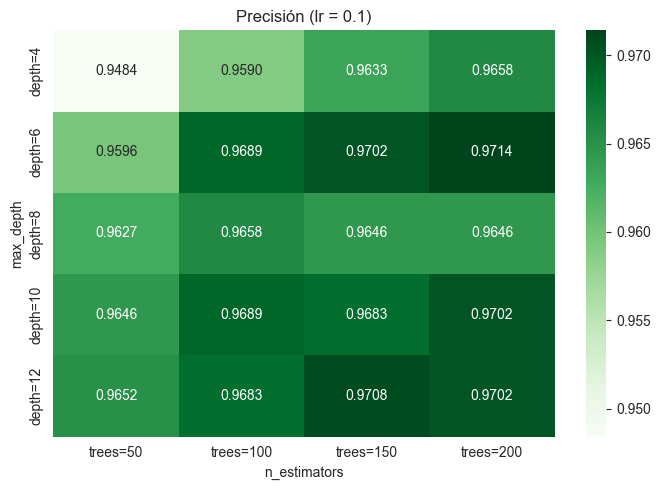

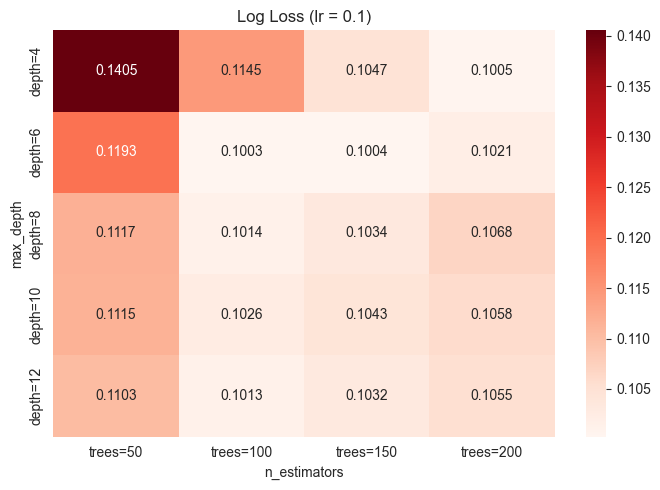

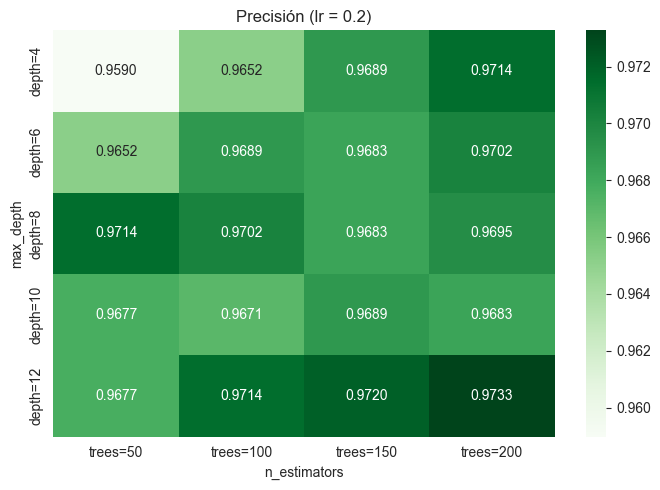

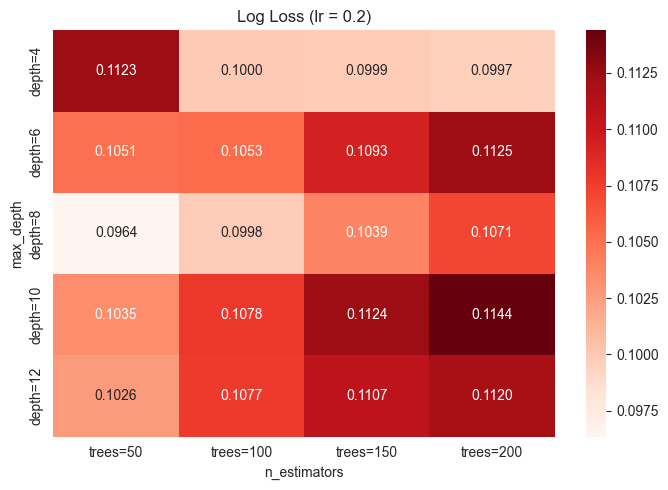

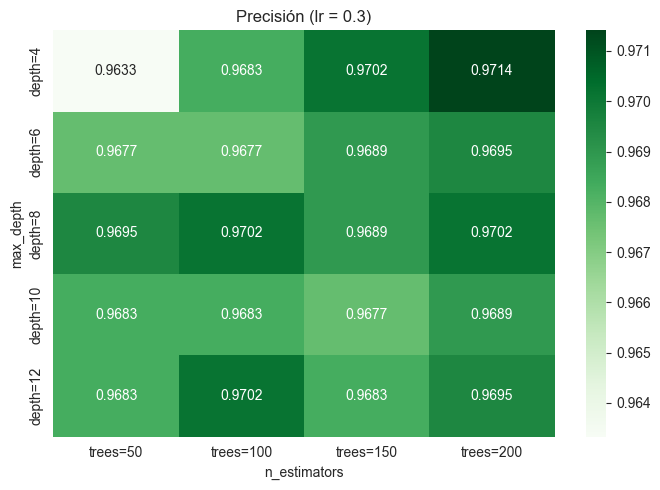

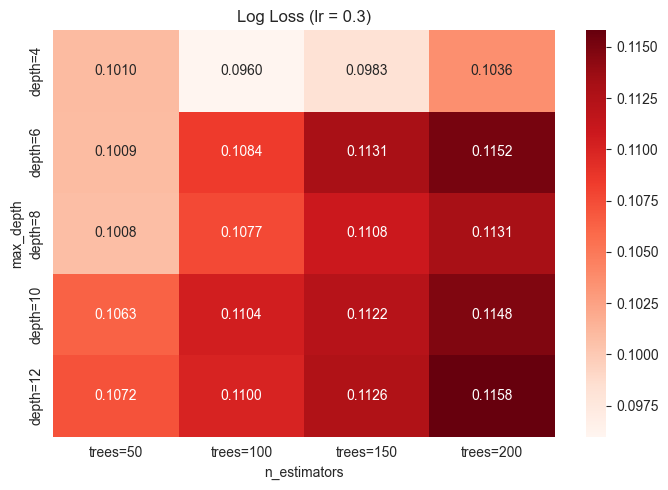

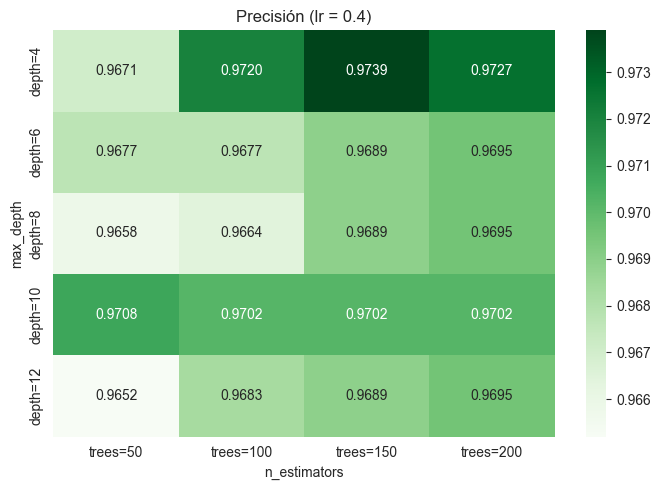

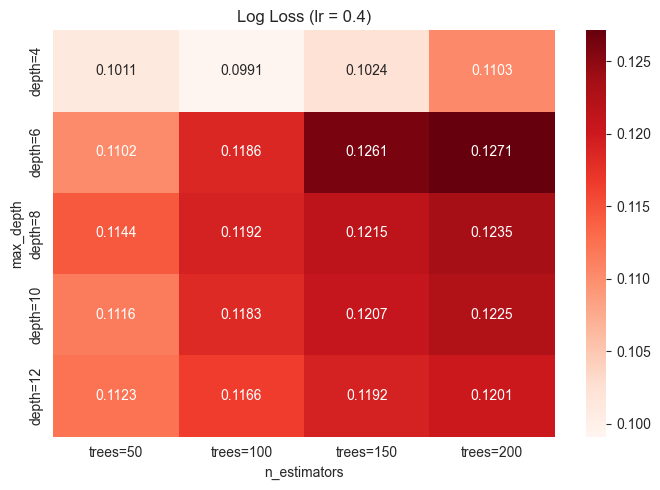

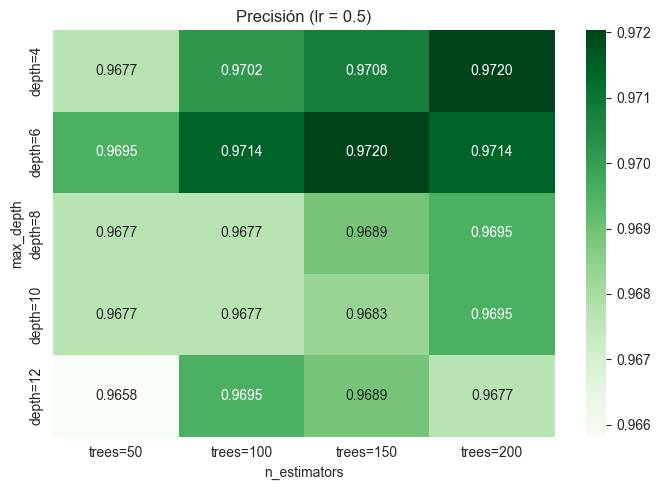

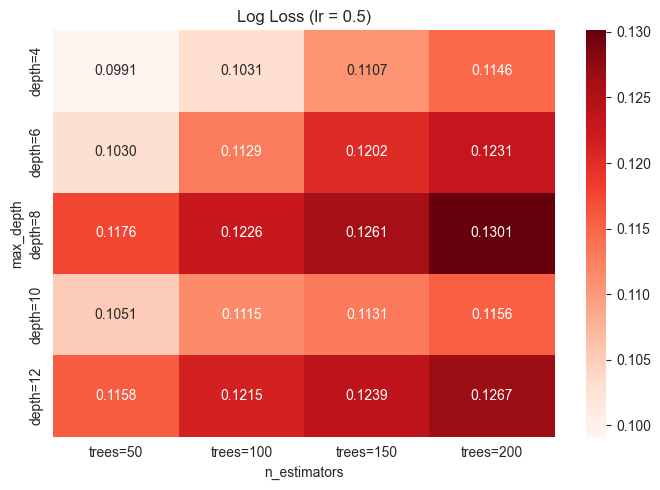

🔹 Mejor Accuracy: 0.9739 con lr = 0.4 , depth = 4 , trees = 150
🔹 Mejor LogLoss : 0.096 con lr = 0.3 , depth = 4 , trees = 100


In [156]:
# 1. Cargar el dataset final
df = pd.read_csv("Data/URL_Train.csv")

# 2. Separar variables y objetivo
X = df.drop(columns=['status'])
y = df['status']

# 3. División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Parámetros a probar
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
depths = [4, 6, 8, 10, 12]
trees = [50, 100, 150, 200]

# 5. Inicializar diccionarios para guardar resultado
acc_results = {}
loss_results = {}

# 6. Entrenamiento por combinación
for lr in learning_rates:
    acc_grid = []
    loss_grid = []
    for d in depths:
        acc_row = []
        loss_row = []
        for t in trees:
            model_url = XGBClassifier(
                learning_rate=lr,
                max_depth=d,
                n_estimators=t,
                use_label_encoder=False,
                eval_metric='logloss',
                verbosity=0,
                random_state=42
            )
            model_url.fit(X_train, y_train)
            y_pred = model_url.predict(X_test)
            y_proba = model_url.predict_proba(X_test)

            acc = accuracy_score(y_test, y_pred)
            loss = log_loss(y_test, y_proba)
            # Guarda las métricas
            acc_row.append(acc)
            loss_row.append(loss)
        # Agrega la fila
        acc_grid.append(acc_row)
        loss_grid.append(loss_row)

    # Convierte los resultados en un DF
    acc_results[f"lr={lr}"] = pd.DataFrame(
        acc_grid,
        index=[f"depth={d}" for d in depths],
        columns=[f"trees={t}" for t in trees]
    )

    loss_results[f"lr={lr}"] = pd.DataFrame(
        loss_grid,
        index=[f"depth={d}" for d in depths],
        columns=[f"trees={t}" for t in trees]
    )

# === 7. Mostrar resultados ===

    # Heatmap precisión
    plt.figure(figsize=(7, 5))
    sns.heatmap(acc_results[f"lr={lr}"], annot=True, fmt=".4f", cmap="Greens")
    plt.title(f"Precisión (lr = {lr})")
    plt.xlabel("n_estimators")
    plt.ylabel("max_depth")
    plt.tight_layout()
    plt.show()

    # Heatmap log loss
    plt.figure(figsize=(7, 5))
    sns.heatmap(loss_results[f"lr={lr}"], annot=True, fmt=".4f", cmap="Reds")
    plt.title(f"Log Loss (lr = {lr})")
    plt.xlabel("n_estimators")
    plt.ylabel("max_depth")
    plt.tight_layout()
    plt.show()

# === 8. Mostrar mejores combinaciones ===
mejor_acc = 0
mejor_params_acc = None
mejor_loss = float("inf")
mejor_params_loss = None

for lr in learning_rates:
    df_acc = acc_results[f"lr={lr}"]
    df_loss = loss_results[f"lr={lr}"]

    for i, d in enumerate(depths):
        for j, t in enumerate(trees):
            acc = df_acc.iloc[i, j]
            loss = df_loss.iloc[i, j]

            if acc > mejor_acc:
                mejor_acc = acc
                mejor_params_acc = (lr, d, t)

            if loss < mejor_loss:
                mejor_loss = loss
                mejor_params_loss = (lr, d, t)

print("🔹 Mejor Accuracy:", round(mejor_acc, 4), "con lr =", mejor_params_acc[0], ", depth =", mejor_params_acc[1], ", trees =", mejor_params_acc[2])
print("🔹 Mejor LogLoss :", round(mejor_loss, 4), "con lr =", mejor_params_loss[0], ", depth =", mejor_params_loss[1], ", trees =", mejor_params_loss[2])

In [157]:
# Cargar dataset
df = pd.read_csv("Data/URL_Train.csv")
X = df.drop(columns=["status"])
y = df["status"]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost
model_url = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.4,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    random_state=42
)
# Entrenar y registrar resultados
model_url.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [158]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Predicciones
y_pred = model_url.predict(X_test)

# Métricas principales
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, model_url.predict_proba(X_test)[:, 1])

# Mostrar resultados
print("=== Resultados del Modelo ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

# Matriz de confusión y resumen
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=4))

=== Resultados del Modelo ===
Accuracy:  0.9720
Precision: 0.9662
Recall:    0.9772
F1 Score:  0.9716
ROC AUC:   0.9927

Matriz de Confusión:
[[793  27]
 [ 18 771]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.9778    0.9671    0.9724       820
           1     0.9662    0.9772    0.9716       789

    accuracy                         0.9720      1609
   macro avg     0.9720    0.9721    0.9720      1609
weighted avg     0.9721    0.9720    0.9720      1609



# Validación del Modelo

In [175]:
# 1. Cargar nuevo dataset con URLs ya convertidas en features
ruta_nuevas_urls = "../Extraction/Data/dataset_procesado.csv"
df_nuevas = pd.read_csv(ruta_nuevas_urls)

# 2. Separar las columnas que no se deben usar en la predicción
X_nuevas = df_nuevas.drop(columns=['URL', 'Label'])

# 3. Predecir probabilidad de phishing
probs = model_url.predict_proba(X_nuevas)[:, 1]  # Probabilidad de clase 1 (phishing)

# 4. Ajustar el umbral manualmente
umbral = 0.5  # Puedes probar con 0.4, 0.5, 0.6, etc.
y_pred = (probs >= umbral).astype(int)

# 5. Añadir resultados al DataFrame
df_nuevas['prob_phishing'] = probs
df_nuevas['prediccion'] = y_pred
df_nuevas['prediccion_texto'] = df_nuevas['prediccion'].map({0: 'Legítimo', 1: 'Phishing'})

# 6. Guardar resultados si deseas
df_nuevas.to_csv('Data/urls_con_predicciones.csv', index=False)


In [176]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# 7. Convertir etiquetas reales
y_true = df_nuevas['Label']

# 8. Métricas
print("=== Resultados del Modelo en Nuevas URLs ===")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_true, probs):.4f}")

# 9. Matriz de confusión
matriz = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusión:")
print(matriz)

# 10. Reporte detallado
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred))

# Mostrar resultado textual para cada fila
print("\n=== Diagnóstico de cada URL ===")
for i in range(len(y_pred)):
    texto = "Phishing" if y_pred[i] == 1 else "Legítimo"
    print(f"→ URL: {df_nuevas.iloc[i]['URL']} → Predicción: {texto} (prob = {probs[i]:.4f})")

=== Resultados del Modelo en Nuevas URLs ===
Accuracy:  1.0000
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC AUC:   nan

Matriz de Confusión:
[[1]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


=== Diagnóstico de cada URL ===
→ URL: gob.pe → Predicción: Legítimo (prob = 0.4538)


C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Daniel R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

In [141]:
joblib.dump(model_url, "../../../../PycharmProjects/FastAPIProject/app/models/mode_detection_url.pkl")
print("Exported Model")

Exported Model
